In [1]:
import pandas as pd, numpy as np, tensorflow as tf, io, json
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D
from keras.models import Model
from Cleaning import clean

In [2]:
# Loading dataset

train = pd.read_csv('Raw Datasets/train.csv', encoding='latin-1')

In [3]:
# Separate train x from y and cleaning the dataset

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"].apply(lambda comment: clean(comment))

In [4]:
# Tokenizing and padding the dataset

max_features = 20000
maxlen = 100

tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

In [5]:
# Saving the tokenizer

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json','w',encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [6]:
# Making the model

# maxlen=100 as defined earlier
inp = Input(shape=(100, ))

# size of the vector space
embed_size = 128
x = Embedding(20000, embed_size)(inp)

output_dimention = 60
x = LSTM(output_dimention, return_sequences=True, name='lstm_layer')(x)
# reduce dimention
x = GlobalMaxPool1D()(x)
# disable 10% precent of the nodes
x = Dropout(0.1)(x)
# pass output through a RELU function
x = Dense(50, activation="relu")(x)
# another 10% dropout
x = Dropout(0.1)(x)
# pass the output through a sigmoid layer, since 
# we are looking for a binary (0,1) classification 
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
# we use binary_crossentropy because of binary classification
# optimise loss by Adam optimiser
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Training the model

hist = model.fit(X_t,y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 253s 56ms/step - loss: 0.0689 - accuracy: 0.9544 - val_loss: 0.0514 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 248s 55ms/step - loss: 0.0462 - accuracy: 0.9870 - val_loss: 0.0489 - val_accuracy: 0.9938


In [8]:
model.save('profanity_model.h5')

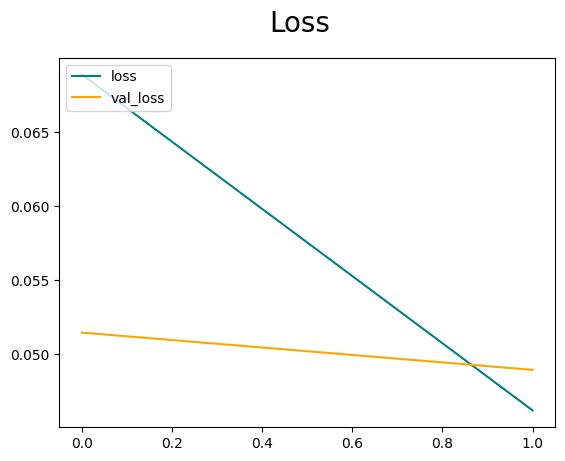

In [9]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

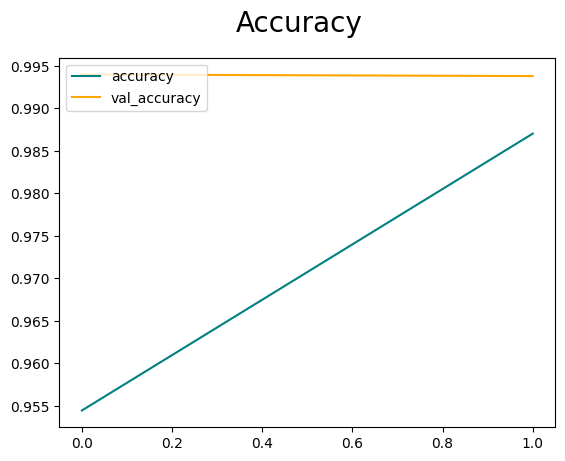

In [10]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()